# **1.- Introducción**

El conteo de células es una tarea fundamental en numerosos estudios biomédicos, como el análisis histológico, la evaluación de muestras celulares o el seguimiento de procesos patológicos. Tradicionalmente, este conteo se realiza de forma manual, lo que resulta lento y subjetivo. El procesamiento digital de imágenes permite automatizar este proceso mediante técnicas clásicas de segmentación, filtrado y análisis de regiones, proporcionando resultados reproducibles y eficientes.



---




En este notebook se pretende llevar a cabo el conteo de células de dos imágenes. La primera imagen consta de antígenos marrones y elementos celulares azules; la segunda solo contiene células epiteliales humanas. El objetivo es contar cuantas células hay (de cada subtipo en la primera) sin conocer el dato.


---


Las dos imágenes fueron importadas desde el ordenador local puesto que la ruta desde one drive producía errores.

# **2.- Importación de librerías**

Importación de las librerias utilizadas a lo largo del notebook

In [19]:
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np

from skimage.filters import gaussian
from skimage.color import rgb2hsv
from skimage.util import img_as_float

from skimage.morphology import remove_small_objects, remove_small_holes, disk, opening, closing
from skimage.measure import label
from skimage.filters import threshold_otsu

import matplotlib.pyplot as plt
from skimage import exposure
from skimage.color import rgb2lab, lab2rgb, rgb2hsv
from skimage.morphology import remove_small_objects, disk, opening

import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import gaussian, threshold_otsu
from skimage.exposure import rescale_intensity
from skimage.morphology import remove_small_objects, remove_small_holes, disk, opening, closing

import matplotlib.pyplot as plt
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, remove_small_holes, disk, opening, closing


import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

from skimage.color import label2rgb
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.color import label2rgb
from skimage.measure import label

from skimage.io import imread
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from skimage.color import label2rgb

from skimage.measure import label

from skimage.morphology import remove_small_objects, remove_small_holes, disk, opening, closing

from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.filters import threshold_local
import numpy as np



# **3.- Imagen 1**

Cargamos y mostramos la primera imágen.

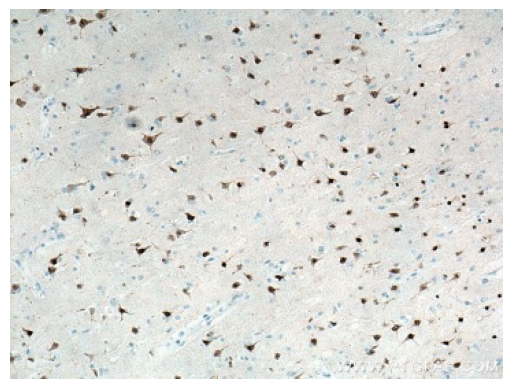

In [8]:
img1 = imread('/Imagen 1.jpg') # Ruta de la imagen en los archivos de colab
plt.imshow(img1)
plt.axis('off')
plt.show()

Se muestran las dimensiones de la imagen con .shape

In [9]:
alto, ancho, canales = img1.shape
print("Alto:", alto)
print("Ancho:", ancho)
print("Canales:", canales)

Alto: 270
Ancho: 360
Canales: 3


# **3.1.- Preprocesado**

Se ha suavizado la imagen mediante un filtro gaussiano para impedir que pequeñas variaciones de intensidad afecten a la posterior umbralización. Se muestra la imagen original para una rápida comparación del proceso.

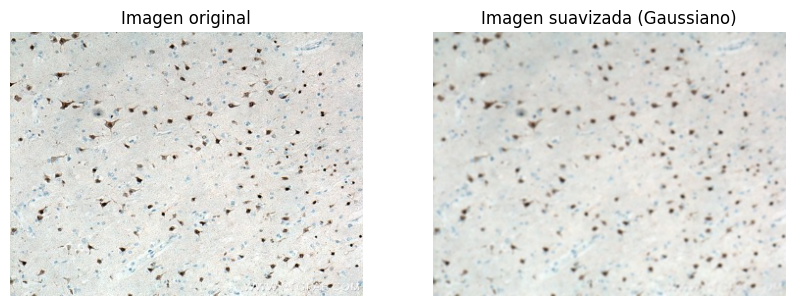

In [12]:
# Suavizado
img1_f = img_as_float(img1)
img1_s = gaussian(img1_f, sigma=1.0, channel_axis=-1)

# Mostrar imagen original y procesada
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img1)
axes[0].set_title("Imagen original")
axes[0].axis("off")

axes[1].imshow(img1_s)
axes[1].set_title("Imagen suavizada (Gaussiano)")
axes[1].axis("off")

plt.show()


# **3.2.- Umbralización**

En esta etapa se segmenta la imagen en función del color utilizando el espacio HSV, que permite separar la información cromática de la iluminación. Se definen rangos de tono, saturación y valor para aislar los antígenos de color marrón y las células de color azul, generando máscaras independientes Las máscaras finales se visualizan junto a la imagen suavizada para verificar la calidad de la segmentación antes del conteo.

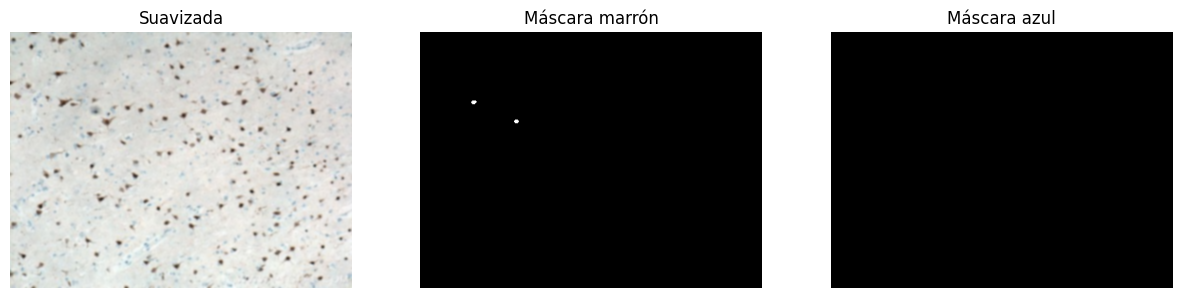

In [13]:
# Conversión de la imagen suavizada al espacio de color HSV
hsv = rgb2hsv(img1_s)
H, S, V = hsv[...,0], hsv[...,1], hsv[...,2]

# Máscara marrón
mask_brown = (H > 0.03) & (H < 0.12) & (S > 0.25) & (V < 0.85) # Rangos iniciales típicos

# Máscara azul
mask_blue  = (H > 0.50) & (H < 0.75) & (S > 0.15) & (V < 0.95) # IDEM

# Limpieza morfológica rápida
se = disk(1) # Elemento estructurante para operaciones morfológicas

mask_brown = opening(mask_brown, se) # Aperturas
mask_brown = closing(mask_brown, se) #Clausuras
mask_brown = remove_small_objects(mask_brown, min_size=15) # Eliminar elementos pequeños
mask_brown = remove_small_holes(mask_brown, area_threshold=15)

mask_blue = opening(mask_blue, se)
mask_blue = closing(mask_blue, se)
mask_blue = remove_small_objects(mask_blue, min_size=15)
mask_blue = remove_small_holes(mask_blue, area_threshold=15)

# Mostrar original y las máscaras
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(img1_s); ax[0].set_title("Suavizada"); ax[0].axis("off")
ax[1].imshow(mask_brown, cmap="gray"); ax[1].set_title("Máscara marrón"); ax[1].axis("off")
ax[2].imshow(mask_blue, cmap="gray"); ax[2].set_title("Máscara azul"); ax[2].axis("off")
plt.show()


A la vista está que los resultados fueron muy malos así que reajustamos los parámetros:

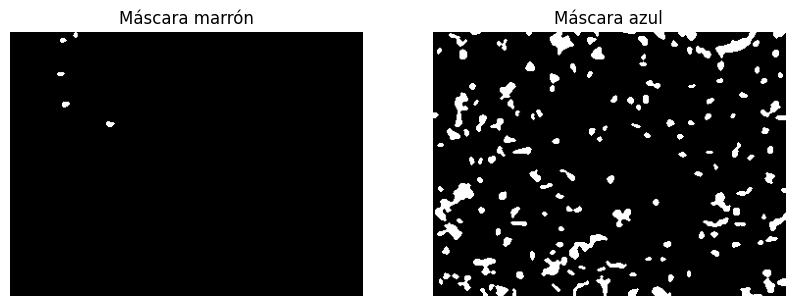

In [14]:
# Conversión de la imagen suavizada al espacio de color HSV
hsv = rgb2hsv(img1_s)
H, S, V = hsv[...,0], hsv[...,1], hsv[...,2]

# Máscaras
mask_brown = (S > 0.15) & (V < 0.75)
mask_blue  = (H > 0.45) & (H < 0.70) & (V > 0.60)

# Limpieza morfológica rápida
se = disk(1)
mask_brown = closing(opening(mask_brown, se), se)
mask_brown = remove_small_objects(mask_brown, min_size=20)
mask_brown = remove_small_holes(mask_brown, area_threshold=20)

mask_blue = closing(opening(mask_blue, se), se)
mask_blue = remove_small_objects(mask_blue, min_size=20)
mask_blue = remove_small_holes(mask_blue, area_threshold=20)

#Mostrar imágenes
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(mask_brown, cmap="gray"); ax[0].set_title("Máscara marrón"); ax[0].axis("off")
ax[1].imshow(mask_blue, cmap="gray"); ax[1].set_title("Máscara azul"); ax[1].axis("off")
plt.show()


# *Canales RGB + método Otsu*

La segmentación inicial por rangos HSV no produjo resultados satisfactorios, por lo que se probó una alternativa basada en contraste entre canales RGB. Se establecieron ponderaciones que realzan el marrón (predominio de R frente a G y B) y el azul (predominio de B frente a R y G). Sobre estos mapas se aplicó una umbralización automática mediante el método de Otsu para obtener máscaras binarias sin ajustar manualmente un umbral.

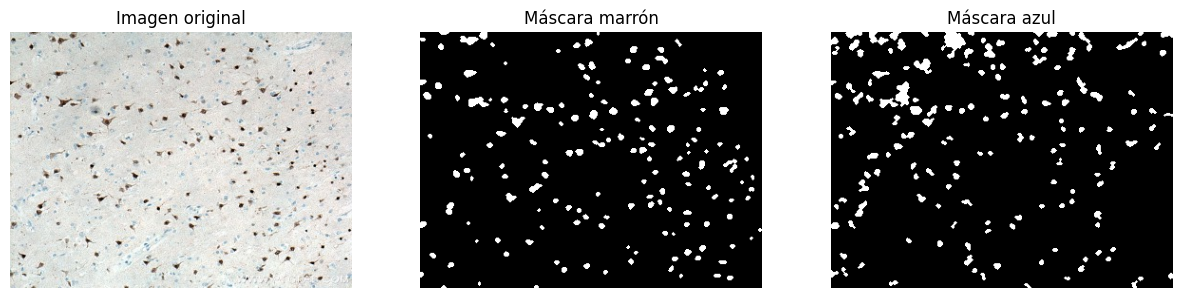

In [15]:

# Canales RGB
R = img1_s[...,0]
G = img1_s[...,1]
B = img1_s[...,2]

# Ponderaciones de color
score_brown = R - 0.65*(G + B)
score_blue  = B - 1*(R + G)

# Umbralización automática (Otsu)
t_brown = threshold_otsu(score_brown)
t_blue  = threshold_otsu(score_blue)

mask_brown = score_brown > t_brown
mask_blue  = score_blue  > t_blue

# Morfología
se = disk(1)

mask_brown = closing(opening(mask_brown, se), se)
mask_brown = remove_small_objects(mask_brown, min_size=10)
mask_brown = remove_small_holes(mask_brown, area_threshold=10)

mask_blue = closing(opening(mask_blue, se), se)
mask_blue = remove_small_objects(mask_blue, min_size=20)
mask_blue = remove_small_holes(mask_blue, area_threshold=20)

# Mostrar original + Máscaras
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].imshow(img1)
ax[0].set_title("Imagen original")
ax[0].axis("off")

ax[1].imshow(mask_brown, cmap="gray")
ax[1].set_title("Máscara marrón")
ax[1].axis("off")

ax[2].imshow(mask_blue, cmap="gray")
ax[2].set_title("Máscara azul")
ax[2].axis("off")

plt.show()

mask_brown_final = mask_brown.copy() # He añadido esto aquí porque, al final del proceso, era la máscara marrón que más me convencía, así la guardo en una variable


La máscara marrón obtuvo resultasdos decentes pero la azul seguía sin convencer. A continuación, para mejorar la detección del azul, se probó una corrección de iluminación y contraste local mediante CLAHE sobre el canal L del espacio LAB, reduciendo los efectos de iluminación no uniforme. Con la imagen realzada, se volvió a segmentar el componente azul en HSV.

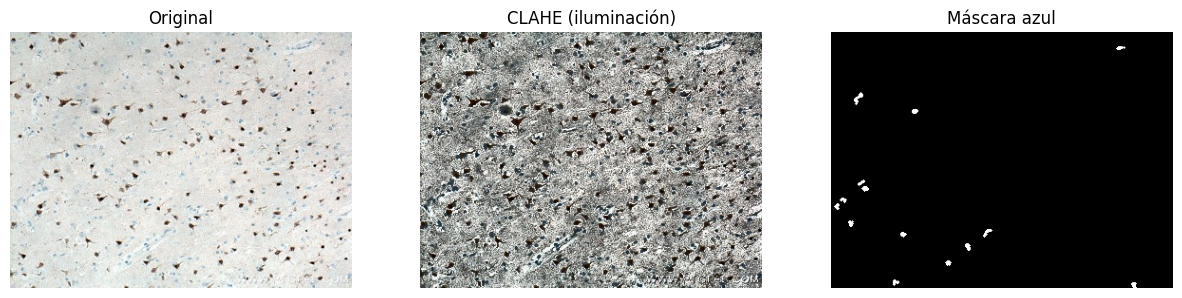

In [20]:
# CLAHE sobre el canal L (luminosidad) en LAB
lab = rgb2lab(img1)                 # imagen original
L = lab[...,0] / 100.0              # L en [0,1]
L_eq = exposure.equalize_adapthist(L, clip_limit=0.03)  # CLAHE
lab_eq = lab.copy()
lab_eq[...,0] = L_eq * 100.0
img_eq = lab2rgb(lab_eq)            # imagen corregida por iluminación/contraste local

# Segmentación azul en HSV sobre la imagen corregida
hsv = rgb2hsv(img_eq)
H, S, V = hsv[...,0], hsv[...,1], hsv[...,2]

mask_blue = (H > 0.50) & (H < 0.72) & (S > 0.10)  # rangos iniciales
mask_blue = opening(mask_blue, disk(1))
mask_blue = remove_small_objects(mask_blue, min_size=25)

# Mostrar  original, corregida y máscara azul
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(img1);    ax[0].set_title("Original"); ax[0].axis("off")
ax[1].imshow(img_eq);  ax[1].set_title("CLAHE (iluminación)"); ax[1].axis("off")
ax[2].imshow(mask_blue, cmap="gray"); ax[2].set_title("Máscara azul"); ax[2].axis("off")
plt.show()


El método anterior claramente no funcionó así que se probó una corrección de iluminación en escala de grises para aumentar el contraste entre células y fondo. Para ello, se estimó el fondo mediante un suavizado gaussiano fuerte y se restó a la imagen, aplicando después un “histogram stretching” para ampliar el rango dinámico. La segmentación se realizó con Otsu.

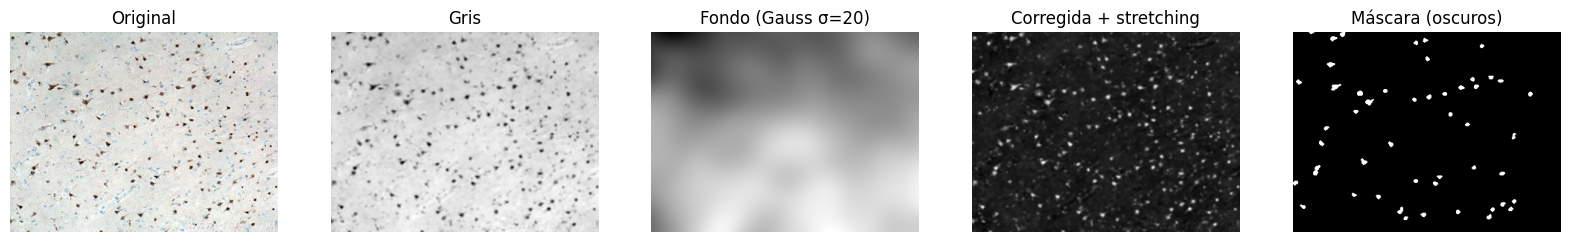

In [21]:
# Gris desde la suavizada
gray = rgb2gray(img1_s)  # img1_s ya está suavizada y en [0,1]

# Estimar fondo (suavizado fuerte) y restarlo (corrección de iluminación)
bg = gaussian(gray, sigma=20)                 # sigma grande = iluminación lenta
corr = bg - gray                              # resalta objetos oscuros
corr = rescale_intensity(corr, in_range='image', out_range=(0,1))  # histogram stretching

# Umbralización (Otsu) sobre corregida
t = threshold_otsu(corr)
mask_dark = corr > t

# Morfología para limpiar
se = disk(1)
mask_dark = closing(opening(mask_dark, se), se)
mask_dark = remove_small_objects(mask_dark, min_size=25)
mask_dark = remove_small_holes(mask_dark, area_threshold=25)

# Mostrar original / gris / fondo / corregida / máscara
fig, ax = plt.subplots(1, 5, figsize=(20,4))
ax[0].imshow(img1); ax[0].set_title("Original"); ax[0].axis("off")
ax[1].imshow(gray, cmap="gray"); ax[1].set_title("Gris"); ax[1].axis("off")
ax[2].imshow(bg, cmap="gray"); ax[2].set_title("Fondo (Gauss σ=20)"); ax[2].axis("off")
ax[3].imshow(corr, cmap="gray"); ax[3].set_title("Corregida + stretching"); ax[3].axis("off")
ax[4].imshow(mask_dark, cmap="gray"); ax[4].set_title("Máscara (oscuros)"); ax[4].axis("off")
plt.show()


Las mejoras seguían sin ser suficientes así que, finalmente, se utilizó una deconvolución de color HED para separar de forma más específica las tinciones. A partir de la imagen suavizada se obtuvieron los canales H (azul) y D (marrón), y se aplicó Otsu en cada uno. Posteriormente, se refinaron ambas máscaras con morfología (apertura/clausura), eliminación de objetos pequeños y relleno de huecos para reducir ruido.

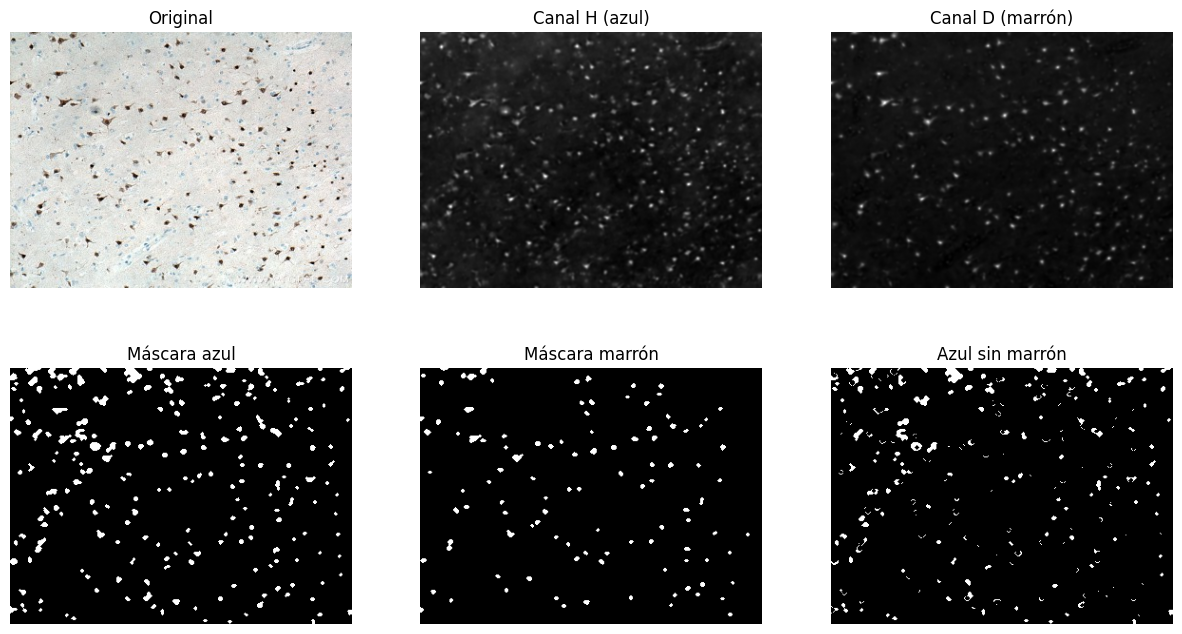

In [22]:
# Deconvolución HED
hed = rgb2hed(img1_s)
H = hed[...,0]   # azul
D = hed[...,2]   # marrón

# Umbralización automática (Otsu)
tH = threshold_otsu(H)
tD = threshold_otsu(D)

mask_blue  = H > tH
mask_brown = D > tD

# Morfología para limpiar
se = disk(1)

mask_blue = closing(opening(mask_blue, se), se)
mask_blue = remove_small_objects(mask_blue, min_size=10)
mask_blue = remove_small_holes(mask_blue, area_threshold=20)

mask_brown = closing(opening(mask_brown, se), se)
mask_brown = remove_small_objects(mask_brown, min_size=10)
mask_brown = remove_small_holes(mask_brown, area_threshold=10)

# Mostrar original / H / D / máscaras
fig, ax = plt.subplots(2, 3, figsize=(15,8))

ax[0,0].imshow(img1); ax[0,0].set_title("Original"); ax[0,0].axis("off")
ax[0,1].imshow(H, cmap="gray"); ax[0,1].set_title("Canal H (azul)"); ax[0,1].axis("off")
ax[0,2].imshow(D, cmap="gray"); ax[0,2].set_title("Canal D (marrón)"); ax[0,2].axis("off")

ax[1,0].imshow(mask_blue, cmap="gray"); ax[1,0].set_title("Máscara azul"); ax[1,0].axis("off")
ax[1,1].imshow(mask_brown, cmap="gray"); ax[1,1].set_title("Máscara marrón"); ax[1,1].axis("off")

# azul sin marrón (por si hay solapamiento)
ax[1,2].imshow(mask_blue & (~mask_brown), cmap="gray")
ax[1,2].set_title("Azul sin marrón")
ax[1,2].axis("off")

plt.show()

mask_blue_final = mask_blue.copy() # Igual que antes con la marrón, me quedo con esta azul


En la siguiente celda se muetsran las máscaras finales para las células marrones y azules:

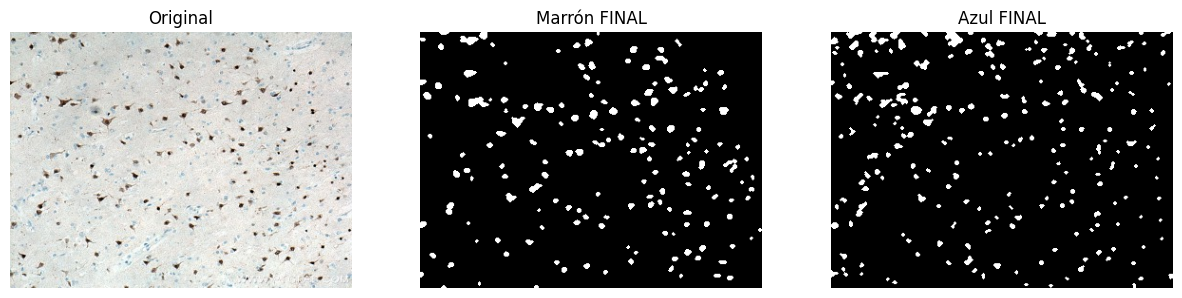

In [31]:
# Mostrar original y máscaras definitivas para azul y marrón
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(img1); ax[0].set_title("Original"); ax[0].axis("off")
ax[1].imshow(mask_brown_final, cmap="gray"); ax[1].set_title("Marrón final"); ax[1].axis("off")
ax[2].imshow(mask_blue_final, cmap="gray"); ax[2].set_title("Azul final"); ax[2].axis("off")
plt.show()


# **3.3.- Conteo de células**

Para el conteo de los elementos segmentados se empleó un etiquetado de componentes sobre las máscaras finales. Cada región etiquetada se considera una instancia independiente y su área se calcula para descartar objetos demasiado pequeños que corresponden a ruido. Mediante un umbral mínimo de área (10 para antígenos y 25 para células) se obtiene el número final de antígenos y células detectadas.

In [32]:
# Función para contar objetos según su área
def count_by_area(mask, min_area=0, max_area=np.inf):
    lab = label(mask)                                  # Etiquetado de componentes conectadas
    props = regionprops(lab)                           # Propiedades de cada región
    areas = np.array([p.area for p in props])          # Área de cada objeto
    keep = (areas >= min_area) & (areas <= max_area)   # Filtrado por tamaño
    return int(np.sum(keep)), lab, areas               # Número de objetos y etiquetas

# Conteo final filtrando ruido por área mínima
antigenos_count, lab_brown, areas_brown = count_by_area(mask_brown_final, min_area=10)
celulas_count,   lab_blue,  areas_blue  = count_by_area(mask_blue_final,  min_area=25)

# Mostrar resultados
print("Antígenos (marrón):", antigenos_count)
print("Elementos celulares (azul):", celulas_count)


Antígenos (marrón): 159
Elementos celulares (azul): 73


# **3.4.- Validación**

Para validar visualmente el conteo obtenido, se superpusieron las etiquetas de las regiones detectadas sobre la imagen original mediante una representación en color (cada componente es un color diferente). Con esto se permite comprobar que las regiones segmentadas corresponden a estructuras reales y que el conteo automático es adecuado a la imagen original.

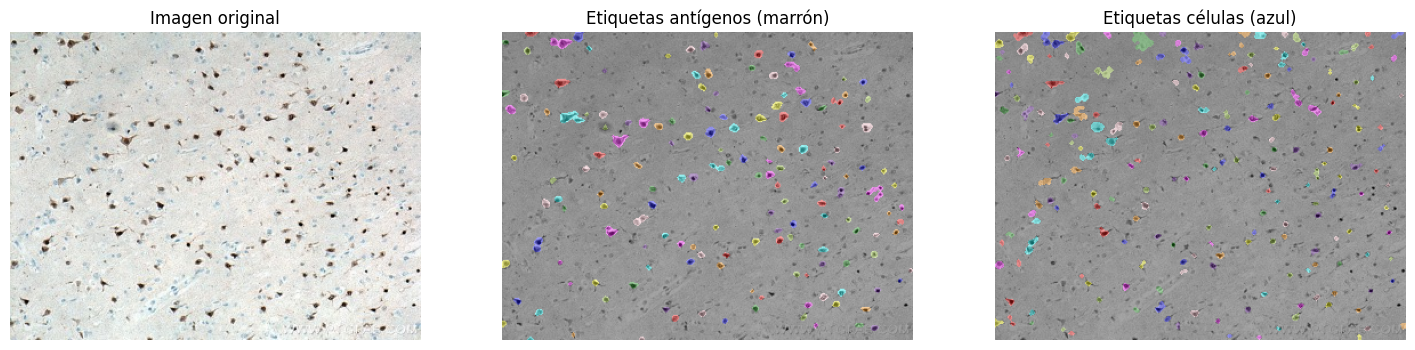

In [37]:
# Superposición etiquetas sobre imagen original
overlay_brown = label2rgb(lab_brown, image=img1, bg_label=0, alpha=0.35)
overlay_blue  = label2rgb(lab_blue,  image=img1, bg_label=0, alpha=0.35)

fig, ax = plt.subplots(1, 3, figsize=(18,6))

# Imagen original
ax[0].imshow(img1)
ax[0].set_title("Imagen original")
ax[0].axis("off")

# Antígenos (marrón)
ax[1].imshow(overlay_brown)
ax[1].set_title("Etiquetas antígenos (marrón)")
ax[1].axis("off")

# Células (azul)
ax[2].imshow(overlay_blue)
ax[2].set_title("Etiquetas células (azul)")
ax[2].axis("off")

plt.show()


# *Watershed*

En esta última celda se aplica el algoritmo watershed para separar objetos que quedan unidos tras la segmentación binaria. A partir de la transformada de distancia se obtienen marcadores mediante máximos locales, que actúan como semillas para dividir regiones conectadas en instancias individuales. Se ajusta el min_distance según el tamaño esperado de los objetos. El resultado se valida visualmente mediante overlays sobre la imagen original, mostrando la mejora en la separación y el conteo. El mejor resultado se obtuvo con min_distanca 5 (azul) y 2 (marrón)

Células AZULES antes: 204
Células AZULES después: 203
Antígenos MARRÓN antes: 159
Antígenos MARRÓN después: 191


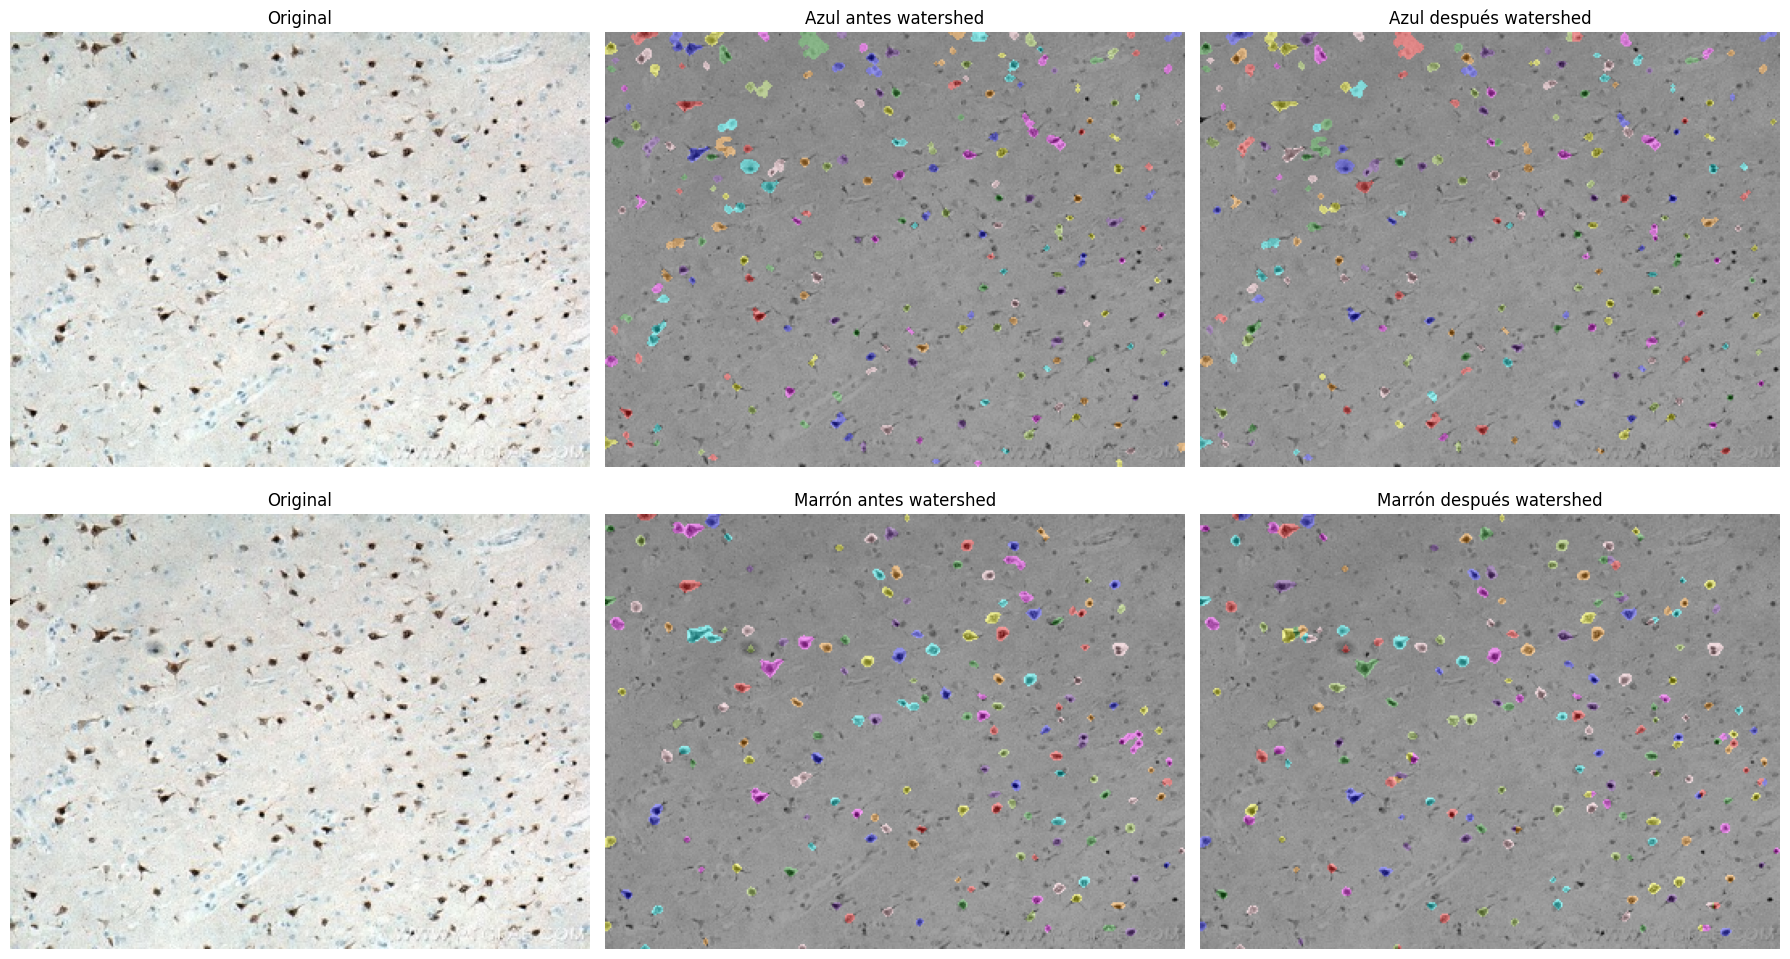

In [42]:
# Watershed para separar objetos pegados en máscara binaria
def watershed_labels(binary_mask, min_distance=8):
    dist = ndi.distance_transform_edt(binary_mask)  # Mapa de distancia (picos en el centro de cada objeto)

    # Marcadores (máximos locales mapa de distancia)
    coords = peak_local_max(dist, min_distance=min_distance, labels=binary_mask)
    markers = np.zeros_like(dist, dtype=np.int32)
    for i, (r, c) in enumerate(coords, start=1):
        markers[r, c] = i

    # Watershed sobre dist, divide regiones conectadas en instancias individuales
    labels_ws = watershed(-dist, markers, mask=binary_mask)
    return labels_ws

# ----------------------Azul-------------------------------------
labels_blue_ws = watershed_labels(mask_blue_final, min_distance=5)

# Overlays antes/después
overlay_blue_before = label2rgb(label(mask_blue_final),
                                image=img1, bg_label=0, alpha=0.35)

overlay_blue_after = label2rgb(labels_blue_ws,
                               image=img1, bg_label=0, alpha=0.35)

print("Células AZULES antes:", label(mask_blue_final).max())
print("Células AZULES después:", labels_blue_ws.max())

# ----------------------Marrón-------------------------------------
labels_brown_ws = watershed_labels(mask_brown_final, min_distance=2)

# Overlays antes/después

overlay_brown_before = label2rgb(label(mask_brown_final),
                                 image=img1, bg_label=0, alpha=0.35)

overlay_brown_after = label2rgb(labels_brown_ws,
                                image=img1, bg_label=0, alpha=0.35)

print("Antígenos MARRÓN antes:", label(mask_brown_final).max())
print("Antígenos MARRÓN después:", labels_brown_ws.max())

# Mostrar
fig, ax = plt.subplots(2, 3, figsize=(18,10))

# Fila azul
ax[0,0].imshow(img1); ax[0,0].set_title("Original"); ax[0,0].axis("off")
ax[0,1].imshow(overlay_blue_before); ax[0,1].set_title("Azul antes watershed"); ax[0,1].axis("off")
ax[0,2].imshow(overlay_blue_after); ax[0,2].set_title("Azul después watershed"); ax[0,2].axis("off")

# Fila marrón
ax[1,0].imshow(img1); ax[1,0].set_title("Original"); ax[1,0].axis("off")
ax[1,1].imshow(overlay_brown_before); ax[1,1].set_title("Marrón antes watershed"); ax[1,1].axis("off")
ax[1,2].imshow(overlay_brown_after); ax[1,2].set_title("Marrón después watershed"); ax[1,2].axis("off")

plt.tight_layout()
plt.show()


# **4.- Imagen 2**



Cargamos la imagen y mostramos sus dimensiones

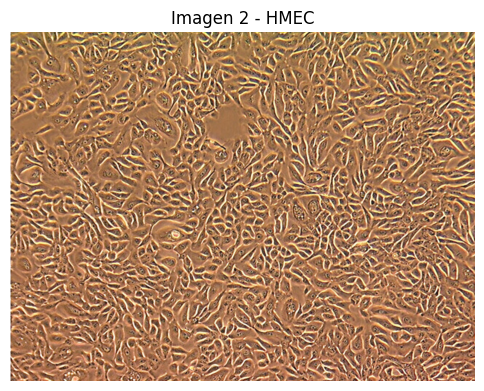

Dimensiones de la imagen 2: (768, 1024, 3)


In [44]:
# Cargar imagen
img2 = imread('/content/Imagen_2.jpeg') # Ruta de la imagen en los archivos de colab

# Mostrar imagen
plt.figure(figsize=(6,6))
plt.imshow(img2)
plt.title("Imagen 2 - HMEC")
plt.axis('off')
plt.show()

# Dimensiones
print("Dimensiones de la imagen 2:", img2.shape)


# **5.1.- Convertir a escala de grises**

Se eliminan las variaciones de color, simplificando el procesado posterior sin alterar características de la imagen.

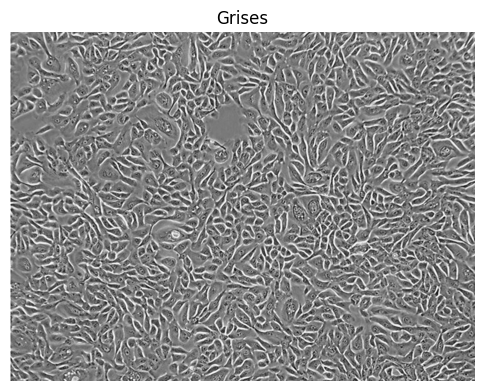

In [45]:
# Conversión a escala de grises
gray2 = rgb2gray(img2)

# Mostrar
plt.figure(figsize=(6,6))
plt.imshow(gray2, cmap="gray")
plt.title("Grises")
plt.axis("off")
plt.show()


# **5.2.- Suavizado**

Se aplica un filtrado gaussiano con el objetivo de reducir el ruido de alta frecuencia, atenuando pequeñas variaciones locales de intensidad que pueden provocar falsas detecciones en la umbralización.

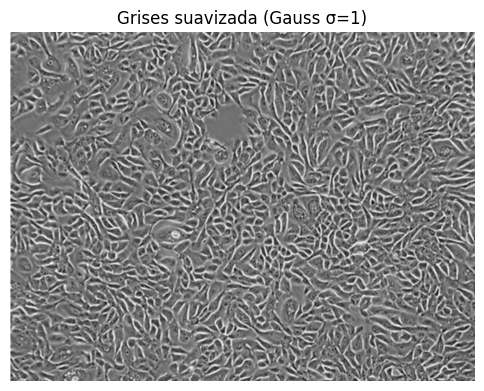

In [46]:
# Suavizado
gray2_s = gaussian(gray2, sigma=1.0)

# Mostrar
plt.figure(figsize=(6,6))
plt.imshow(gray2_s, cmap="gray")
plt.title("Grises suavizada (Gauss σ=1)")
plt.axis("off")
plt.show()


# **5.3.-Umbralización**

Para segmentar las células en presencia de iluminación no uniforme, se utilizó una umbralización adaptativa basada en ventanas locales. Este método calcula un umbral distinto para cada región, lo que permite compensar variaciones de iluminación y contraste. Mediante el ajuste del tamaño de ventana (71 en vez de 51) y del parámetro de desplazamiento (offset lo subimos a 0,04), se obtiene una máscara binaria que resalta los núcleos celulares sobre un fondo negro.

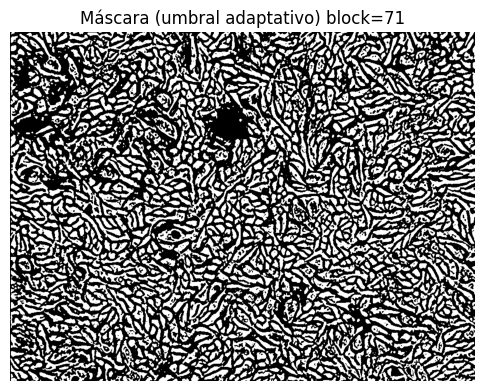

In [58]:
# Umbralización adaptativa (para iluminación no uniforme)
block_size = 71                                                   # Cambié de 51 a 71
T = threshold_local(gray2_s, block_size=block_size, offset=0.04)  # Cambié de -0.02 a 0.04

# Generación máscara
mask = gray2_s < T

# Mostrar
plt.figure(figsize=(6,6))
plt.imshow(mask, cmap="gray")
plt.title(f"Máscara (umbral adaptativo) block={block_size}")
plt.axis("off")
plt.show()


# **5.4- Limpieza morfológica**

Para obtener una segmentación más limpia y adecuada para el conteo final se aplicaron operaciones de morfología matemática para mejorar su calidad. Mediante apertura y clausura se eliminaron pequeñas regiones de ruido y se suavizaron los contornos de las células. También se descartaron objetos de tamaño reducido y se rellenaron huecos internos para conservar únicamente las regiones correspondendientes a núcleos celulares.

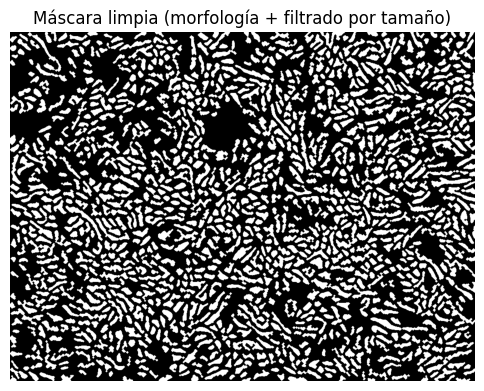

In [64]:

# Morfología para limpiar
se = disk(2)

mask_clean = opening(mask, se)
mask_clean = closing(mask_clean, se)
mask_clean = remove_small_objects(mask_clean, min_size=80)
mask_clean = remove_small_holes(mask_clean, area_threshold=80)

# Mostrar
plt.figure(figsize=(6,6))
plt.imshow(mask_clean, cmap="gray")
plt.title("Máscara limpia (morfología + filtrado por tamaño)")
plt.axis("off")
plt.show()


# **5.5- Etiquetado y conteo**

Con todo el procesado llevado a cabo exitosamente, procedimos al conteo. A cada región conectada se le asigna una etiqueta distinta. El número total de células se obtiene contando el número máximo de etiquetas generadas.

In [60]:
# Etiquetado de componentes conectadas en la máscara final
labels = label(mask_clean)
count = labels.max()  # Número total de células detectadas

# Mostrar resultado
print("Células (aprox.) detectadas:", count)


Células (aprox.) detectadas: 1182


# **5.6- Validación visual**

Por último, validamos visualmente el resultado del conteo superponiendo las etiquetas de las regiones segmentadas sobre la imagen original. Cada célula detectada se representa con un color diferente, facilitando la comprobación de que la segmentación es coherente con la estructura real de la imagen y que el conteo automático es razonable.

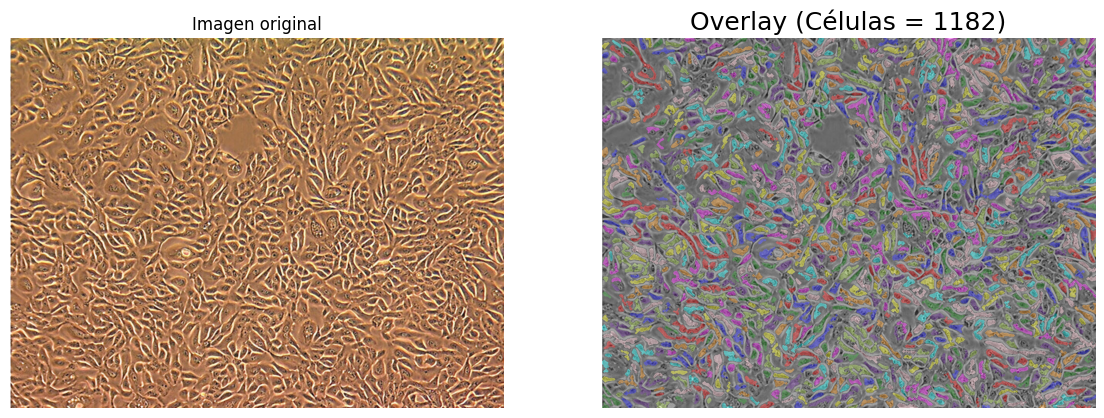

In [62]:
# Superposición de las etiquetas sobre la imagen original
count = labels.max()
overlay = label2rgb(labels, image=img2, bg_label=0, alpha=0.35)

# Mostrar original y superpuesta con células contadas
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].imshow(img2)
ax[0].set_title("Imagen original")
ax[0].axis("off")

ax[1].imshow(overlay)
ax[1].set_title(f"Overlay (Células = {count})", fontsize=18)
ax[1].axis("off")

plt.show()


# **6.- Conclusiones globales**

En este trabajo se ha abordado el conteo celular mediante técnicas clásicas de procesamiento de imágenes, aplicando distintos métodos de segmentación, pre y postprocesado en función de las características de cada imagen.


---


Somos conscientes de que los resultados obtenidos no representan un conteo óptimo debido a la complejidad del fondo y a la similitud cromática entre algunos elementos, especialmente en la primera imagen. No obstante, con más tiempo de desarrollo sería posible mejorar los resultados ajustando parámetros con mayor precisión o probando métodos adicionales.

En el caso de la segunda imagen, el conteo se considera más fiable, ya que las células presentan una estructura más homogénea, aunque tampoco puede asumirse como completamente exacto.


---


Aun así, los resultados obtenidos son relativamente coherentes y muestran el potencial del procesamiento de imágenes para automatizar este tipo de tareas.